In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
from typing import List

In [2]:
from torch.utils.data import Dataset, DataLoader
DATA_FOLDER = 'mask_output/images'


# Data loading + splits (train/val/test)
Images are read from `mask_output/images` and the class label is parsed from the filename (pattern: `..._annotX_<CLASS>_image.png`).

In [15]:
import os
import re
from pathlib import Path
from collections import defaultdict, Counter
from typing import Dict, Tuple, Optional, Sequence
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Subset


In [16]:
_LABEL_RE = re.compile(r"_annot\d+_(?P<label>.+?)_image\.(png|jpg|jpeg)$", flags=re.IGNORECASE)

def label_from_filename(path: str) -> str:
    """Extract class label from filename like '..._annot0_Tumor_image.png'."""
    name = Path(path).name
    m = _LABEL_RE.search(name)
    if not m:
        raise ValueError(f"Cannot parse label from filename: {name}")
    label = m.group("label").strip()
    # Some files have trailing underscores (e.g. 'Ignore_' / 'Region_'); normalize.
    label = label.strip("_")
    return label

def list_image_files(data_folder: str, exts: Sequence[str] = (".png", ".jpg", ".jpeg")) -> list[Path]:
    root = Path(data_folder)
    if not root.exists():
        raise FileNotFoundError(f"DATA_FOLDER not found: {root.resolve()}")
    files: list[Path] = []
    for ext in exts:
        files.extend(root.rglob(f"*{ext}"))
        files.extend(root.rglob(f"*{ext.upper()}"))
    files = sorted({p for p in files if p.is_file()})
    if not files:
        raise FileNotFoundError(f"No images found under: {root.resolve()}")
    return files

def square_crop_boxes(w: int, h: int, three_ratio_min: float = 2.8, three_ratio_max: float = 3.2) -> list[tuple[int, int, int, int]]:
    """Return 1 (center) square crop, or 3 sliding square crops if ratio ~ 1:3."""
    if w <= 0 or h <= 0:
        return []
    if w == h:
        return [(0, 0, w, h)]

    long_side = max(w, h)
    short_side = min(w, h)
    ratio = long_side / short_side

    # If image is roughly 1:3, cut into 3 squares along long dimension.
    if three_ratio_min <= ratio <= three_ratio_max:
        sq = short_side
        if w >= h:
            # horizontal layout
            if w == 3 * h:
                starts = [0, h, 2 * h]
            else:
                # sliding windows: left, center, right (may discard borders)
                starts = [0, max(0, (w - sq) // 2), max(0, w - sq)]
            return [(s, 0, s + sq, sq) for s in starts]
        else:
            # vertical layout
            if h == 3 * w:
                starts = [0, w, 2 * w]
            else:
                starts = [0, max(0, (h - sq) // 2), max(0, h - sq)]
            return [(0, s, sq, s + sq) for s in starts]

    # Otherwise: center-crop to square (discard borders).
    sq = short_side
    left = (w - sq) // 2
    top = (h - sq) // 2
    return [(left, top, left + sq, top + sq)]

class FilenameLabelImageDataset(Dataset):
    def __init__(
        self,
        data_folder: str,
        transform: Optional[object] = None,
        exclude_classes: Optional[set[str]] = None,
    ):
        self.data_folder = data_folder
        self.transform = transform
        exclude_classes = exclude_classes or set()
        self.exclude_classes = exclude_classes
        exclude_lc = {c.lower() for c in exclude_classes}

        files = list_image_files(data_folder)
        labels = [label_from_filename(p.name) for p in files]
        keep = [i for i, lab in enumerate(labels) if lab.lower() not in exclude_lc]
        self.files = [files[i] for i in keep]
        self.labels_str_files = [labels[i] for i in keep]

        classes = sorted(set(self.labels_str_files))
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.idx_to_class = {i: c for c, i in self.class_to_idx.items()}

        # Expand each image into 1 or 3 square crops depending on aspect ratio.
        samples: list[tuple[Path, tuple[int, int, int, int]]] = []
        labels_str: list[str] = []
        for path, lab in zip(self.files, self.labels_str_files):
            with Image.open(path) as im:
                w, h = im.size
            for box in square_crop_boxes(w, h):
                samples.append((path, box))
                labels_str.append(lab)

        self.samples = samples
        self.labels_str = labels_str
        self.targets = [self.class_to_idx[c] for c in self.labels_str]

    def with_transform(self, transform: Optional[object]):
        ds = object.__new__(FilenameLabelImageDataset)
        ds.data_folder = self.data_folder
        ds.transform = transform
        ds.exclude_classes = self.exclude_classes
        ds.files = self.files
        ds.labels_str_files = self.labels_str_files
        ds.class_to_idx = self.class_to_idx
        ds.idx_to_class = self.idx_to_class
        ds.samples = self.samples
        ds.labels_str = self.labels_str
        ds.targets = self.targets
        return ds

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int):
        path, box = self.samples[idx]
        image = Image.open(path).convert("RGB")
        image = image.crop(box)
        if self.transform is not None:
            image = self.transform(image)
        y = self.targets[idx]
        return image, y

    def class_counts(self) -> Counter:
        return Counter(self.labels_str)


In [17]:
def make_transforms(image_size: int = 224, train: bool = True):
    # Minimal baseline; swap/extend for augmentation later.
    ops = [
        T.Resize((image_size, image_size)),
    ]
    if train:
        # Example augmentation hook (keep minimal):
        ops.append(T.RandomHorizontalFlip(p=0.5))
        ops.append(T.RandomVerticalFlip(p=0.5))
        ops.append(T.RandomRotation(degrees=90))

    ops += [
        T.ToTensor(),
        # ImageNet normalization works well with torchvision pretrained backbones.
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return T.Compose(ops)

def stratified_split_indices(labels: Sequence[int], train_frac: float = 0.7, val_frac: float = 0.15, test_frac: float = 0.15, seed: int = 42) -> Tuple[list[int], list[int], list[int]]:
    if not (0 < train_frac < 1 and 0 <= val_frac < 1 and 0 <= test_frac < 1):
        raise ValueError("Fractions must be in [0,1] and train_frac in (0,1)")
    total = train_frac + val_frac + test_frac
    if abs(total - 1.0) > 1e-6:
        raise ValueError(f"Fractions must sum to 1.0, got {total}")

    rng = torch.Generator().manual_seed(seed)
    by_class: Dict[int, list[int]] = defaultdict(list)
    for i, y in enumerate(labels):
        by_class[int(y)].append(i)

    train_idx: list[int] = []
    val_idx: list[int] = []
    test_idx: list[int] = []

    for y, idxs in by_class.items():
        idxs = idxs.copy()
        # deterministic shuffle per class
        perm = torch.randperm(len(idxs), generator=rng).tolist()
        idxs = [idxs[i] for i in perm]
        n = len(idxs)
        n_test = int(round(test_frac * n))
        n_val = int(round(val_frac * n))
        # Ensure we don't exceed n and keep train >= 1 when possible
        if n >= 3:
            n_test = max(1, n_test)
            n_val = max(1, n_val)
        if n_test + n_val >= n:
            # back off val/test if the class is tiny
            n_test = min(n_test, max(0, n - 1))
            n_val = min(n_val, max(0, n - 1 - n_test))
        n_train = n - n_val - n_test
        if n_train <= 0 and n > 0:
            n_train = 1
            if n_val > 0:
                n_val -= 1
            elif n_test > 0:
                n_test -= 1
        train_idx.extend(idxs[:n_train])
        val_idx.extend(idxs[n_train:n_train + n_val])
        test_idx.extend(idxs[n_train + n_val:])

    # final shuffle to mix classes
    def _shuffle(xs: list[int]) -> list[int]:
        if not xs:
            return xs
        perm = torch.randperm(len(xs), generator=rng).tolist()
        return [xs[i] for i in perm]

    return _shuffle(train_idx), _shuffle(val_idx), _shuffle(test_idx)

def make_dataloaders(
    data_folder: str,
    batch_size: int = 32,
    image_size: int = 224,
    train_frac: float = 0.7,
    val_frac: float = 0.15,
    test_frac: float = 0.15,
    seed: int = 42,
    num_workers: int = 0,
    exclude_classes: Optional[set[str]] = None,
 ):
    train_tf = make_transforms(image_size=image_size, train=True)
    eval_tf = make_transforms(image_size=image_size, train=False)

    # Build once (expanding 1:3 images into 3 squares), then reuse crops across splits/transforms.
    base_ds = FilenameLabelImageDataset(data_folder, transform=None, exclude_classes=exclude_classes)
    train_idx, val_idx, test_idx = stratified_split_indices(base_ds.targets, train_frac, val_frac, test_frac, seed=seed)

    train_ds = base_ds.with_transform(train_tf)
    val_ds = base_ds.with_transform(eval_tf)
    test_ds = base_ds.with_transform(eval_tf)

    train_subset = Subset(train_ds, train_idx)
    val_subset = Subset(val_ds, val_idx)
    test_subset = Subset(test_ds, test_idx)

    pin_memory = torch.cuda.is_available()
    loaders = {
        "train": DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory),
        "val": DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory),
        "test": DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory),
    }
    meta = {
        "class_to_idx": base_ds.class_to_idx,
        "idx_to_class": base_ds.idx_to_class,
        "counts": base_ds.class_counts(),
        "sizes": {"train": len(train_subset), "val": len(val_subset), "test": len(test_subset)},
    }
    return loaders, meta


In [18]:
# ---- Pipeline scaffold (extend later) ----
CFG = {
    "data_folder": DATA_FOLDER,
    "batch_size": 32,
    "image_size": 224,
    "splits": {"train": 0.70, "val": 0.15, "test": 0.15},
    "seed": 42,
    "num_workers": 0,
    # Drop non-learning labels here (case-insensitive).
    "exclude_classes": {"Region"},
}

dataloaders, data_meta = make_dataloaders(
    data_folder=CFG["data_folder"],
    batch_size=CFG["batch_size"],
    image_size=CFG["image_size"],
    train_frac=CFG["splits"]["train"],
    val_frac=CFG["splits"]["val"],
    test_frac=CFG["splits"]["test"],
    seed=CFG["seed"],
    num_workers=CFG["num_workers"],
    exclude_classes=CFG["exclude_classes"],
 )

print("Classes:", data_meta["class_to_idx"])
print("Counts:", data_meta["counts"])
print("Split sizes:", data_meta["sizes"])

# Quick sanity-check batch
xb, yb = next(iter(dataloaders["train"]))
print("Batch x:", tuple(xb.shape), "Batch y:", tuple(yb.shape), "y sample:", yb[:8].tolist())


Classes: {'Ignore': 0, 'Necrosis': 1, 'Stroma': 2, 'Tumor': 3}
Counts: Counter({'Stroma': 448, 'Ignore': 407, 'Necrosis': 192, 'Tumor': 184})
Split sizes: {'train': 861, 'val': 185, 'test': 185}
Batch x: (32, 3, 224, 224) Batch y: (32,) y sample: [0, 0, 3, 1, 0, 0, 2, 0]
Batch x: (32, 3, 224, 224) Batch y: (32,) y sample: [0, 0, 3, 1, 0, 0, 2, 0]


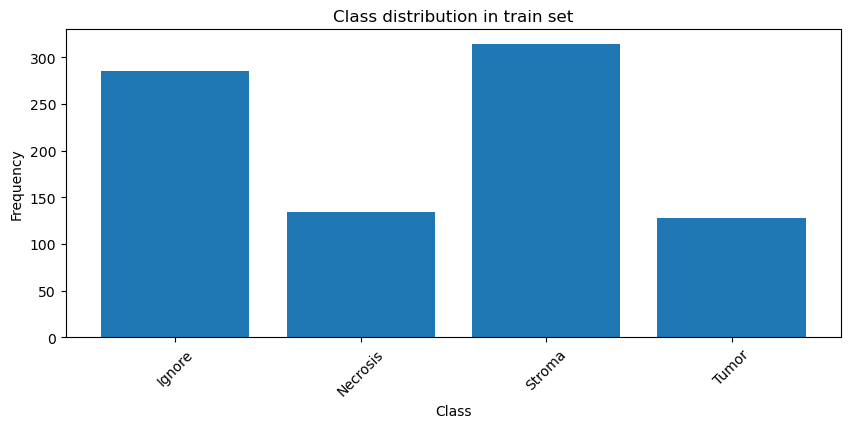

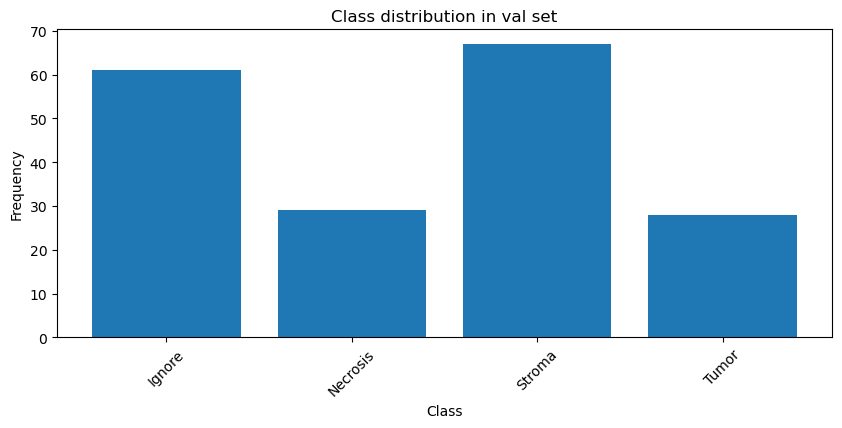

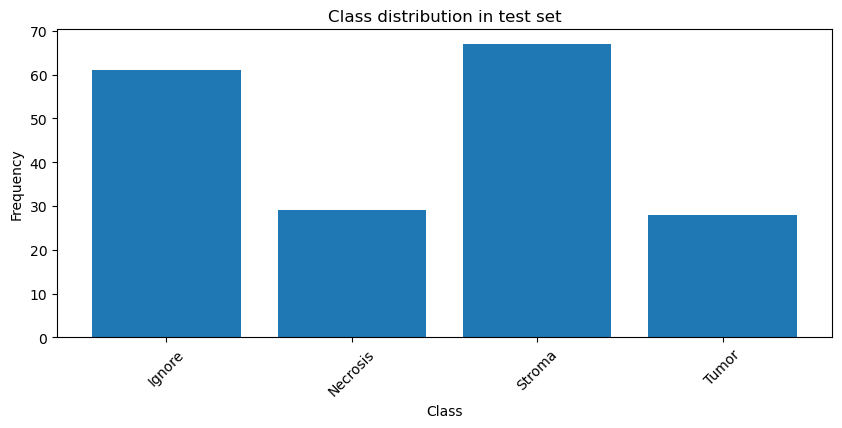

In [19]:
import matplotlib.pyplot as plt
# Check balance of classes in splits
for split in ["train", "val", "test"]:
    loader = dataloaders[split]
    all_labels: List[int] = []
    for _, y in loader:
        all_labels.extend(y.tolist())
    counts = Counter(all_labels)
    labels = list(data_meta["idx_to_class"].values())
    freqs = [counts.get(i, 0) for i in range(len(labels))]
    plt.figure(figsize=(10, 4))
    plt.bar(labels, freqs)
    plt.title(f"Class distribution in {split} set")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
import tqdm

class CNN(nn.Module): 
    def __init__(self, num_classes: int):
        super(CNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
        return probs
    
    def evaluate(self, dataloader: DataLoader, device: torch.device):
        self.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                logits = self.forward(x)
                _, predicted = torch.max(logits, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        accuracy = correct / total if total > 0 else 0.0
        return accuracy
    
model = CNN(num_classes=len(data_meta["class_to_idx"]))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(10): 
    for x, y in tqdm.tqdm(dataloaders["train"]):
        # plt.imshow(T.ToPILImage()(x[0]))
        # plt.show()
        outputs = model(x)
        loss = criterion(outputs, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} validation accuracy: {model.evaluate(dataloaders['val'], device=torch.device('cpu')):.4f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example forward pass
outputs = model(xb.to(device))
print("Output shape:", outputs.shape) 

print(f"Accuracy on test set: {model.evaluate(dataloaders['test'], device):.4f}")


/Users/dimitri/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dimitri/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 27/27 [01:15<00:00,  2.81s/it]


Epoch 1 validation accuracy: 0.5351


 41%|████      | 11/27 [00:31<00:45,  2.86s/it]